# Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import sqlite3
import os
import gpumangrove.utils as gmu

from scipy import stats

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec

# IPython
from IPython.core.display import display, HTML

In [2]:
# Notebook Layout - Run to set the width of jupyter cells to 100%
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Matplotlib Parameters
mpl.rc('xtick', labelsize=13)
mpl.rc('ytick', labelsize=13)
mpl.rc('axes', labelsize=15)
#mpl.rcParams.keys()

# Datasources

In [4]:
### Input ###
# GPU models
gpus = [ 'K20', 'TitanXp', 'P100', 'V100', 'GTX1650']
# sample aggregation
agg = 'median'
# threshold for samples with same bench,app,dataset key
threshold = '100'
data_dir = 'data'
file_features = data_dir + '/FeatureTable-0.3.db'

## Time ##
files_time_samples = {}
files_time_samples_f = {}
files_time_model = {}
files_time_cv_res = {}
files_time_loo = {}
files_time_kernel = {}


for gpu in gpus:
    files_time_samples[gpu] = (data_dir + '/time_samples_' + gpu + '_' + agg + '.db')
    files_time_samples_f[gpu] = (data_dir + '/time_samplesf_' + gpu + '_' + agg + '_' + threshold + '.pkl')
    files_time_model[gpu] = (data_dir + '/time_model_' + gpu + '_' + agg + '_' + threshold + '.pkl')
    files_time_cv_res[gpu] = (data_dir + '/time_cv-res_' + gpu + '_' + agg + '_' + threshold + '.pkl')
    files_time_loo[gpu] = (data_dir + '/time_loo_' + gpu + '_' + agg + '_' + threshold + '.pkl')
    files_time_kernel[gpu] = (data_dir + '/KernelTime-' + gpu + '.db')
    
## Power ##
files_power_samples = {}
files_power_samples_f = {}
files_power_model = {}
files_power_cv_res = {}
files_power_loo = {}
files_power_kernel = {}

for gpu in gpus:
    files_power_samples[gpu] = (data_dir + '/power_samples_' + gpu + '_' + agg + '.db')
    files_power_samples_f[gpu] = (data_dir + '/power_samplesf_' + gpu + '_' + agg + '_' + threshold + '.pkl')
    files_power_model[gpu] = (data_dir + '/power_model_' + gpu + '_' + agg + '_' + threshold + '.pkl')
    files_power_cv_res[gpu] = (data_dir + '/power_cv-res_' + gpu + '_' + agg + '_' + threshold + '.pkl')
    files_power_loo[gpu] = (data_dir + '/power_loo_' + gpu + '_' + agg + '_' + threshold + '.pkl')
    files_power_kernel[gpu] = (data_dir + '/KernelPower-' + gpu + '.db')

### Output ###
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Ground Truth

## Execution Time

### Execution Time Variance

In [5]:
def readRTData(featureTableName, KTs):
    res = {}
    for gpu in KTs:
        with sqlite3.Connection(featureTableName) as conn:
            df_features = pd.read_sql_query("select * from fluxfeatures", conn)

        with sqlite3.Connection(KTs[gpu]) as conn:
            df_time = pd.read_sql_query("select * from kerneltime", conn)

        time_groups = df_time.merge(df_features, on=['bench','app','dataset','lseq'], how='inner').groupby(
            ['bench','app','dataset','name','gX','gY','gZ','bX','bY','bZ','shm','control','int.32','int.64','total_inst'])['time']

        data = pd.DataFrame({'mean': time_groups.mean(), 'median':time_groups.median(), 'std': time_groups.std(), 
                             'q10' : time_groups.quantile(q=0.1), 'q90' : time_groups.quantile(q=0.9), 
                             'min' : time_groups.min(), 'max' : time_groups.max()})
        time_groups = None
        data.sort_values('mean',inplace=True)
        res[gpu] = data
    return res

In [6]:
RTdata = readRTData(file_features, files_time_kernel)

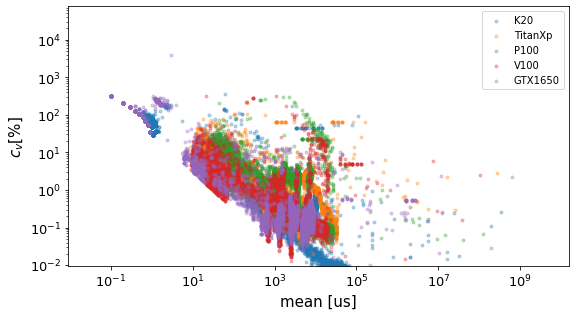

In [7]:
fig, ax1 = plt.subplots(1,1,figsize=(10.8*0.75,6*0.75))

for gpu in RTdata:

    df = RTdata[gpu]
    x = np.arange(len(df))    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_ylabel(r'$c_v [\%]$')
    ax1.set_xlabel('mean [us]')
    ax1.scatter(df['mean'], 100*df['std']/df['mean'], marker=".", label=gpu,alpha=.3)
    tmp = df[df['std']/df['mean'] > 4]    

fig.tight_layout()
plt.legend()
plt.savefig(plot_dir + '/Time_deviation.pdf')
plt.savefig(plot_dir + '/Time_deviation.png')
plt.show()

### Execution Time Histogram

In [8]:
time_array = []
labels = []

for gpu in files_time_samples:
    labels.append(gpu)
    with sqlite3.Connection(files_time_samples[gpu]) as conn:
        df = pd.read_sql_query("select * from samples", conn)
        df = df[df['time'] > 0]
        time_array.append(df['time'])

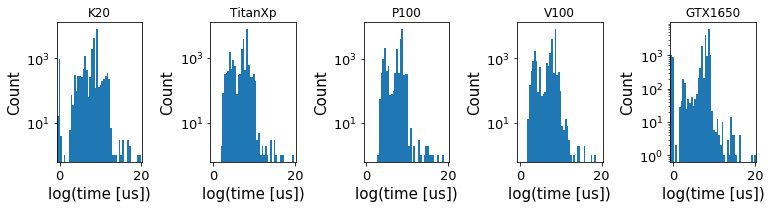

In [9]:
min = float('Inf')
max = 0.0

for time in time_array:
    if time.min() < min:
        min = time.min()
    if time.max() > max:
        max = time.max()

fig, axes = plt.subplots(1,5,figsize=(10.8,3))
i = 0
for time in time_array:
    res = stats.cumfreq(time, numbins=100,defaultreallimits=(min,max))
    x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

    axes[i].set_title(labels[i])
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('log(time [us])')
    axes[i].hist(np.log(time), bins=50, range=(np.log(min),np.log(max)))
    axes[i].set_xlim(np.log([min, max]))
    axes[i].set_yscale('log')
    i += 1
plt.tight_layout()
plt.savefig(plot_dir+'/Time_distribution.pdf')
plt.show()

## Power

### Power Variance

In [10]:
# Input
## Database Paths
power_stat_dbs = ['data/stat_K20.db',
       'data/stat_GTX1650.db',
       'data/stat_TitanX.db',
       'data/stat_P100.db',
       'data/stat_V100.db'
      ]

def readRPData(KPs):
    res = {}
    for powerTableName in KPs:
        with sqlite3.Connection(powerTableName) as conn:
            df_power = pd.read_sql_query("select * from statistics", conn)
        data = pd.DataFrame({'mean': df_power['mean'], 'median': df_power['median'], 'std': df_power['stdev'], 'count': df_power['count']})
        GPU_name = powerTableName.split('_')[1]
        GPU_name = GPU_name.split('.')[0]
        print(GPU_name)
        res[GPU_name] = data
    return res

data = readRPData(power_stat_dbs)

K20
GTX1650
TitanX
P100
V100


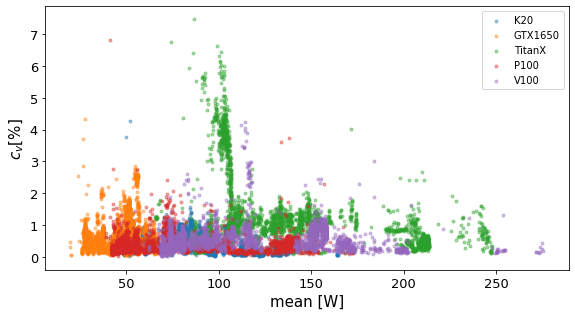

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10.8*0.75,6*0.75))

for gpu in data:
    df = data[gpu]
    x = np.arange(len(df))
    ax.scatter(df['mean'], 100*df['std']/df['mean'], marker=".", label=gpu,alpha=.4)
    plt.xlabel('mean [W]')
    plt.ylabel(r'$c_v [\%]$')

fig.tight_layout()
plt.legend()
plt.savefig('plots/Power_deviation.pdf')
plt.show()

### Power Histogram

# K20 Case Study

## Nested Cross-Validation

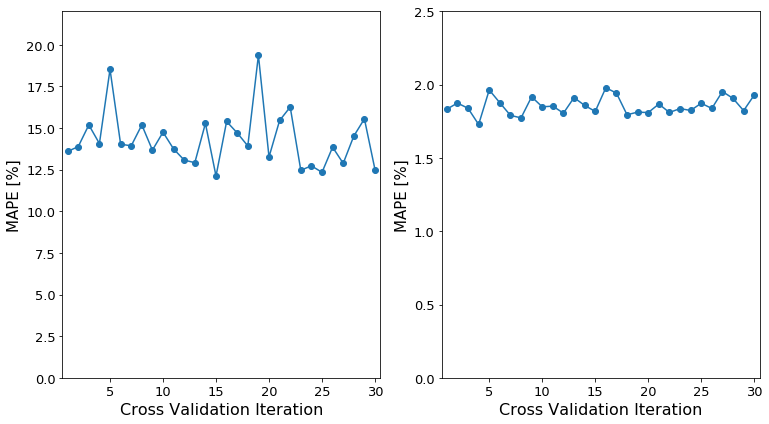

In [12]:
K20_cv_res = pickle.load(open(files_time_cv_res['K20'], "rb"))
K20_scores = [x['ns_scores'] for x in K20_cv_res]
time_cv_mean_K20 = -1 * np.mean(np.array(K20_scores),axis=1)
time_x = np.arange(len(time_cv_mean_K20)) + 1

K20_cv_res = pickle.load(open(files_power_cv_res['K20'], "rb"))
K20_scores = [x['ns_scores'] for x in K20_cv_res]
power_cv_mean_K20 =-1 * np.mean(np.array(K20_scores),axis=1)


power_x = np.arange(len(power_cv_mean_K20)) + 1

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.8,6))

# Time Plot
ax1.plot(time_x,time_cv_mean_K20,  marker='o')
ax1.set_ylabel('MAPE [%]')
ax1.set_xlabel('Cross Validation Iteration',fontsize=16)
ax1.set_ylim(bottom=0,top=22)
ax1.set_xlim((0.5, 30.5))

# Power Plot
ax2.plot(power_x,power_cv_mean_K20,  marker='o')
ax2.set_ylabel('MAPE [%]')
ax2.set_xlabel('Cross Validation Iteration',fontsize=16)
ax2.set_ylim(bottom=1,top=3)
ax2.set_xlim((0.5, 30.5))
ax2.set_ylim((0, 2.5))

fig.tight_layout()
plt.savefig(plot_dir+'/K20_CV_Score.pdf')
plt.show()

In [13]:
print('time',np.sort(time_cv_mean_K20))
print('power',np.sort(power_cv_mean_K20))

time [12.11298388 12.33779808 12.45972341 12.49947755 12.72869608 12.87651976
 12.91659498 13.07164784 13.25955475 13.59099314 13.67127589 13.73856896
 13.847356   13.88122366 13.9215387  13.92822423 14.02688553 14.06582931
 14.51545468 14.70334959 14.74622601 15.18215578 15.18267017 15.27472732
 15.38927091 15.44928059 15.54782685 16.25719891 18.52139469 19.36774798]
power [1.72846704 1.77336248 1.79065947 1.79479793 1.80565824 1.80975093
 1.81037457 1.8127096  1.81754235 1.82278296 1.82406108 1.83295776
 1.83686528 1.83774893 1.83896198 1.84882661 1.85367613 1.85858053
 1.86784721 1.87335435 1.87461237 1.87652129 1.9064192  1.9117053
 1.91724252 1.92915814 1.94283773 1.95343021 1.96398543 1.97891137]


## Feature Importance

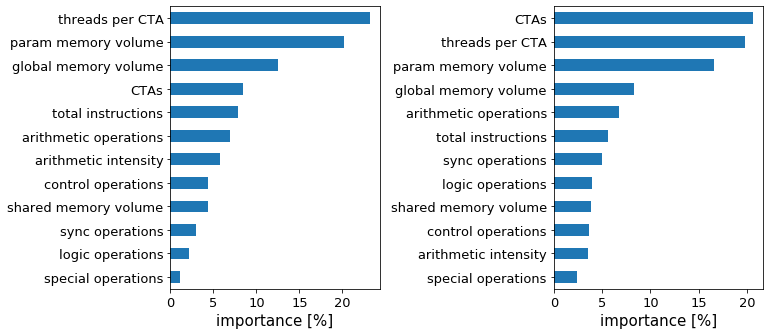

In [14]:
time_k20_dataset = pickle.load(open(files_time_samples_f['K20'],"rb"))
time_model = pickle.load(open(files_time_model['K20'],"rb"))
time_y_labels = [' '.join(label.split('_')) for label in time_k20_dataset.columns.values[4:-1]]
time_feature_importance = 100 * time_model.regressor_.feature_importances_
time_df = pd.DataFrame({'Importance':time_feature_importance}, index=time_y_labels)
time_df.sort_values('Importance', inplace=True)

power_k20_dataset = pickle.load(open(files_power_samples_f['K20'],"rb"))
power_model = pickle.load(open(files_power_model['K20'],"rb"))
power_y_labels = [' '.join(label.split('_')) for label in power_k20_dataset.columns.values[4:-1]]
power_feature_importance = 100 * power_model.feature_importances_
power_df = pd.DataFrame({'Importance':power_feature_importance}, index=power_y_labels)
power_df.sort_values('Importance', inplace=True)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.8,6*0.75))
time_df.plot.barh(legend=False,ax=ax1)
power_df.plot.barh(legend=False,ax=ax2)
plt.tight_layout()
ax1.set_xlabel('importance [%]')
ax2.set_xlabel('importance [%]')
plt.savefig(plot_dir+'/K20_FI.pdf')
plt.show()

## LOO

### Time Predictions

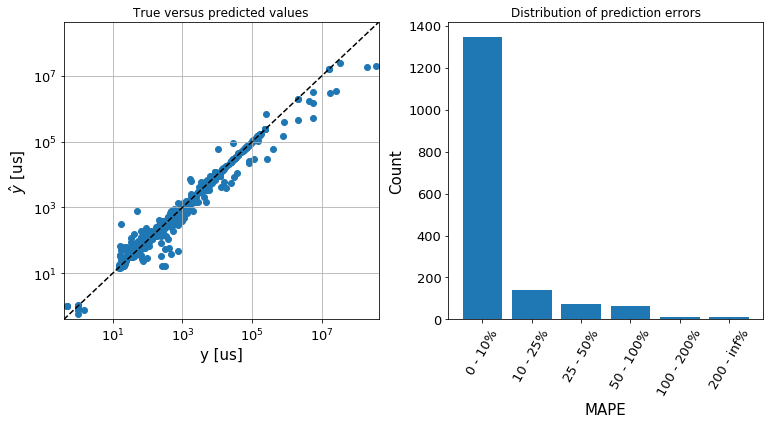

In [15]:
k20_loo_pred = pickle.load(open(data_dir + "/time_loo_K20_median_100.pkl", "rb"))
k20_dataset = pickle.load(open(data_dir + "/time_samplesf_K20_median_100.pkl","rb"))
k20_mape = 100 * np.abs(k20_dataset['time'] - k20_loo_pred)/k20_dataset['time']
time = k20_dataset['time'].values
guide_min = time.min()*0.8
guide_max = time.max()*1.2

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.8,6))

ax1.scatter(time, k20_loo_pred)
ax1.plot([guide_min,guide_max], [guide_min,guide_max], '--', label='', color='black')
ax1.set_xlabel('y [us]')
ax1.set_ylabel(r'$\^y$ [us]')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([guide_min,guide_max])
ax1.set_xlim([guide_min,guide_max])
ax1.set_title("True versus predicted values")
ax1.grid()

bins=[0, 10, 25, 50, 100, 200, float("Inf")]
count, edges = np.histogram(k20_mape, bins=bins)

x = np.arange(len(count))
xticklabels = []
for i in range(0,len(edges)-1):
    xticklabels.append(str(edges[i]).rstrip('0').rstrip('.')+" - "+str(edges[i+1]).rstrip('0').rstrip('.')+"%")

ax2.bar(x, count, tick_label=xticklabels)
ax2.set_ylabel('Count')
ax2.set_xlabel('MAPE')
ax2.xaxis.set_tick_params(rotation=60)
ax2.set_title("Distribution of prediction errors")
fig.tight_layout()
plt.savefig(plot_dir + '/time_K20_LOO_Score.pdf')
plt.show()

In [16]:
print('Summary for each error class:')

for label,val in zip(xticklabels, count):
    print (label,'\t',100*val/k20_mape.shape[0],'%')

Summary for each error class:
0 - 10% 	 81.59806295399515 %
10 - 25% 	 8.41404358353511 %
25 - 50% 	 4.539951573849879 %
50 - 100% 	 3.9346246973365617 %
100 - 200% 	 0.847457627118644 %
200 - inf% 	 0.6658595641646489 %


### Power Predictions

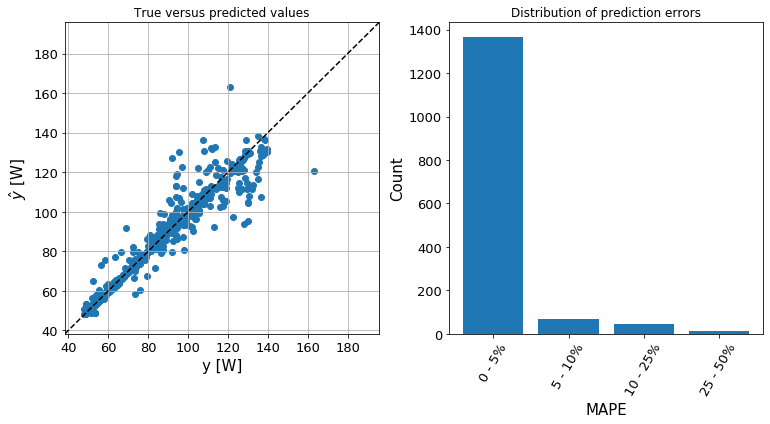

In [17]:
k20_loo_pred = pickle.load(open(data_dir + "/power_loo_K20_median_100.pkl", "rb"))
k20_dataset = pickle.load(open(data_dir + "/power_samplesf_K20_median_100.pkl","rb"))
k20_mape = 100 * np.abs(k20_dataset['power'] - k20_loo_pred)/k20_dataset['power']
time = k20_dataset['power'].values
guide_min = time.min()*0.8
guide_max = time.max()*1.2

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.8,6))

ax1.scatter(time, k20_loo_pred)
ax1.plot([guide_min,guide_max], [guide_min,guide_max], '--', label='', color='black')
ax1.set_xlabel('y [W]')
ax1.set_ylabel(r'$\^y$ [W]')
ax1.set_ylim([guide_min,guide_max])
ax1.set_xlim([guide_min,guide_max])
ax1.set_title("True versus predicted values")
ax1.grid()

bins=[float(0), 5, 10, 25, 50]
count, edges = np.histogram(k20_mape, bins=bins)

x = np.arange(len(count))
xticklabels = []
for i in range(0,len(edges)-1):
    xticklabels.append(str(edges[i]).rstrip('0').rstrip('.')+" - "+str(edges[i+1]).rstrip('0').rstrip('.')+"%")

ax2.bar(x, count, tick_label=xticklabels)
ax2.set_ylabel('Count')
ax2.set_xlabel('MAPE')
ax2.xaxis.set_tick_params(rotation=60)
ax2.set_title("Distribution of prediction errors")
fig.tight_layout()
plt.savefig(plot_dir + '/power_K20_LOO_Score.pdf')
plt.show()

In [18]:
print('Summary for each error class:')

for label,val in zip(xticklabels, count):
    print (label,'\t',100*val/k20_mape.shape[0],'%')

Summary for each error class:
0 - 5% 	 91.30434782608695 %
5 - 10% 	 4.682274247491639 %
10 - 25% 	 3.1438127090301005 %
25 - 50% 	 0.8695652173913043 %


# Cross-Validation

## Boxplots

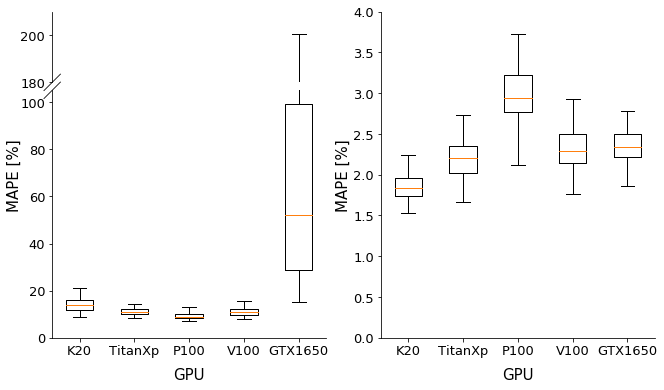

In [19]:
# Time Data
t_data = []
for gpu in files_time_cv_res:
    cv_res = pickle.load(open(files_time_cv_res[gpu], "rb"))
    t_data.append(np.array([x['ns_scores'] for x in cv_res]).ravel()*(-1))
    
# Power Data
p_data = []
for gpu in files_power_cv_res:
    cv_res = pickle.load(open(files_power_cv_res[gpu], "rb"))
    p_data.append(np.array([x['ns_scores'] for x in cv_res]).ravel()*(-1))
    
fig = plt.figure(figsize=(10.8,6))
sps1, sps2 = GridSpec(1,2,figure=fig)
pos = np.array(range(len(gpus))) + 1

# Time Plot
ax1 = brokenaxes(ylims=((0, 105), (180, 210)), hspace=.05, subplot_spec=sps1)
bp = ax1.boxplot(t_data, sym='k+', showfliers=False)

ax1.set_xlabel('GPU')
ax1.set_ylabel('MAPE [%]')
ax1.set_xticklabels(['']+gpus)

# Power Plot
ax2 = brokenaxes( hspace=.05, subplot_spec=sps2)
bp = ax2.boxplot(p_data, sym='k+', showfliers=False)

ax2.set_xlabel('GPU')
ax2.set_ylabel('MAPE [%]')
ax2.set_xticklabels(['']+gpus)
ax2.set_ylim(bottom=0,top=4)
plt.savefig(plot_dir+'/CV_Scores_Boxplot.pdf')
#plt.show()

In [20]:
print("*** time ***")
print("GPU: median, first quartile, third quartile")
for cv_res,gpu in zip(t_data,gpus):
    print(gpu,np.median(cv_res),np.quantile(cv_res, 0.25),np.quantile(cv_res, 0.75))
    
print("\n*** power ***")
print("GPU: median, first quartile, third quartile")
for cv_res,gpu in zip(p_data,gpus):
    print(gpu,np.median(cv_res),np.quantile(cv_res, 0.25),np.quantile(cv_res, 0.75))

*** time ***
GPU: median, first quartile, third quartile
K20 13.862152363594085 11.657003309198876 16.018345163861085
TitanXp 10.959667538807109 10.30506362696834 12.254663532042976
P100 8.864860762361051 8.203808368136837 10.194732714389119
V100 10.893144810792641 9.87312563953352 12.293897867781553
GTX1650 52.00279764408893 28.91225020251234 99.23467745981785

*** power ***
GPU: median, first quartile, third quartile
K20 1.8367647505480198 1.7373144780815217 1.9573364150799304
TitanXp 2.2073195069785525 2.025698588114256 2.353900900163695
P100 2.9374067756390616 2.7725442420736623 3.227927510686485
V100 2.2968889976199756 2.143075711290604 2.4954151866605434
GTX1650 2.339143726616066 2.218998136337066 2.5051351354989086


## Histogram

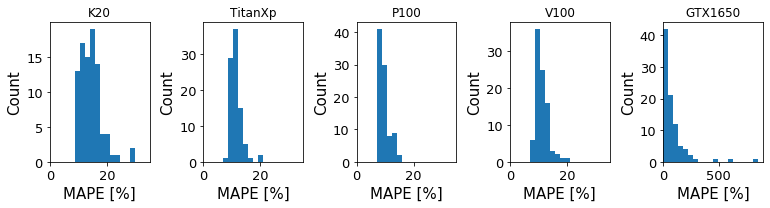

In [21]:
fig, axes = plt.subplots(1,5,figsize=(10.8,3))

i = 0
for cv_res,gpu in zip(t_data,gpus):
    #axes[i] = fig.add_subplot(len(GPUs), i, 1)
    upper_limit = 35
    if gpu == 'GTX1650':
        upper_limit = 900
    
    axes[i].hist(cv_res, bins=20, range=(0, upper_limit))
    axes[i].set_xlim(0,upper_limit)
    axes[i].set_title(gpu)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('MAPE [%]')
    i += 1

plt.tight_layout()
plt.savefig(plot_dir + '/CV_Histogram_time.pdf')
plt.show()

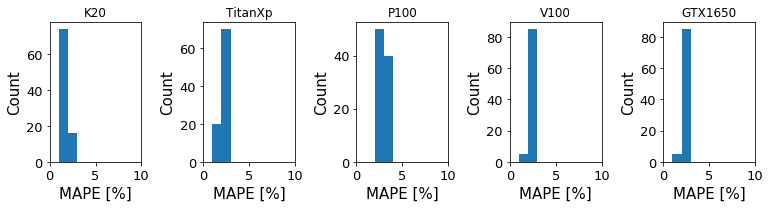

In [22]:
fig, axes = plt.subplots(1,5,figsize=(10.8,3))

i = 0
for cv_res,gpu in zip(p_data,gpus):
    axes[i].hist(cv_res, bins=10, range=(0, 10))
    axes[i].set_xlim(0,10)
    axes[i].set_title(gpu)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('MAPE [%]')
    i += 1

plt.tight_layout()
plt.savefig(plot_dir + '/CV_Histogram_power.pdf')
plt.show()

## Model Parameters

In [23]:
# Model timing
import random
import time

### Time

In [24]:
av_max_depth = list()
av_count_nodes = list()
estimators = list()
timing = list()
critirions = list()
for gpu in gpus:
    dataset = pickle.load(open(files_time_samples_f[gpu],"rb"))
    model = pickle.load(open(files_time_model[gpu],"rb"))
    X = dataset.iloc[:, 4:-1]
    y = dataset.iloc[:, -1]

    #Model characteristics
    max_depth = list()
    max_leaf_nodes = list()

    for tree in model.regressor_.estimators_:
        max_depth.append(tree.tree_.max_depth)
        max_leaf_nodes.append(tree.tree_.node_count)

    estimators.append(model.regressor_.n_estimators)    
    
    #Define one jobs for one prediction, otherwise a delay is observed due to potential overhead of creating more jobs
    model.n_jobs=1
    model.check_inverse = False
    iterations = 1000
    elapsed = np.zeros(iterations)
    for i in range(iterations):
        features = X.sample(random_state=random.randint(0,1e9))
        start = time.time()
        model.predict(features)
        end = time.time()
        elapsed[i] = end - start

    av_max_depth.append(sum(max_depth) / len(max_depth))
    av_count_nodes.append(sum(max_leaf_nodes)/len(max_leaf_nodes))
    critirions.append(model.regressor_.criterion)
    timing.append(elapsed.mean())
df = pd.DataFrame(list(zip(gpus, estimators, av_max_depth, av_count_nodes, critirions, timing)), 
               columns =['GPUs', 'Estimators', 'Depth', 'Leafs', 'Criterion', 'Prediction Latency']) 
df 

,GPUs,Estimators,Depth,Leafs,Criterion,Prediction Latency
0,K20,512,34.830078,2824.632812,mae,0.204653
1,TitanXp,512,33.304688,2881.730469,mae,0.204434
2,P100,512,34.941406,2916.179688,mae,0.202664
3,V100,512,34.308594,2749.800781,mae,0.206488
4,GTX1650,256,31.058594,2157.421875,mse,0.112846


### Power

In [25]:
av_max_depth = list()
av_count_nodes = list()
estimators = list()
timing = list()
critirions = list()
for gpu in gpus:
    dataset = pickle.load(open(files_power_samples_f[gpu],"rb"))
    model = pickle.load(open(files_power_model[gpu],"rb"))
    X = dataset.iloc[:, 4:-1]
    y = dataset.iloc[:, -1]

    #Model characteristics
    max_depth = list()
    max_leaf_nodes = list()

    for tree in model.estimators_:
        max_depth.append(tree.tree_.max_depth)
        max_leaf_nodes.append(tree.tree_.node_count)

    estimators.append(model.n_estimators)    
    
    #Define one jobs for one prediction, otherwise a delay is observed due to potential overhead of creating more jobs
    model.n_jobs=1
    iterations = 1000
    elapsed = np.zeros(iterations)
    for i in range(iterations):
        features = X.sample(random_state=random.randint(0,1e9))
        start = time.time()
        model.predict(features)
        end = time.time()
        elapsed[i] = end - start

    av_max_depth.append(sum(max_depth) / len(max_depth))
    av_count_nodes.append(sum(max_leaf_nodes)/len(max_leaf_nodes))
    critirions.append(model.criterion)
    timing.append(elapsed.mean())
df = pd.DataFrame(list(zip(gpus, estimators, av_max_depth, av_count_nodes, critirions, timing)), 
               columns =['GPUs', 'Estimators', 'Depth', 'Leafs', 'Criterion', 'Prediction Latency']) 
df 

,GPUs,Estimators,Depth,Leafs,Criterion,Prediction Latency
0,K20,256,32.082031,2763.671875,mae,0.034098
1,TitanXp,256,33.445312,2795.312500,mae,0.033671
2,P100,512,32.494141,2859.914062,mae,0.066130
3,V100,1024,32.910156,2836.193359,mse,0.130998
4,GTX1650,1024,32.189453,2312.998047,mae,0.130797


## Feature Importance

### Time

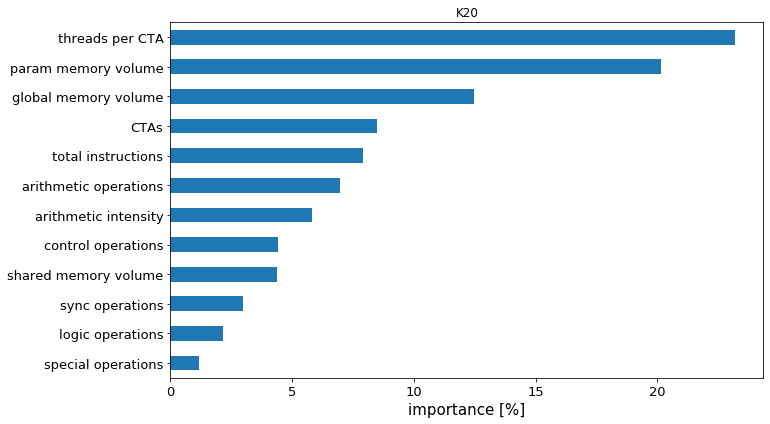

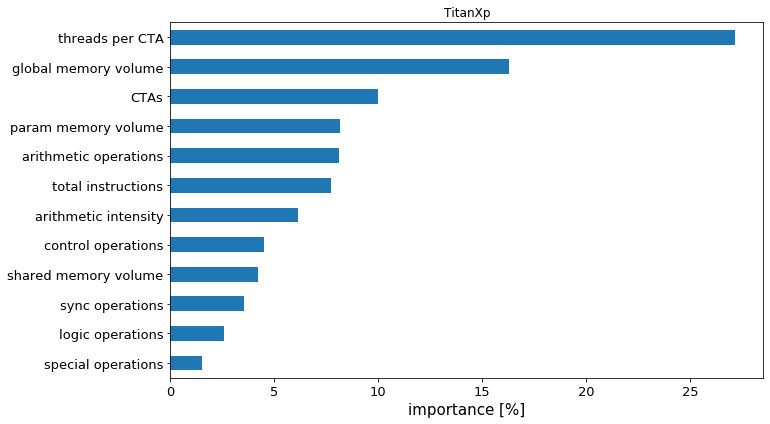

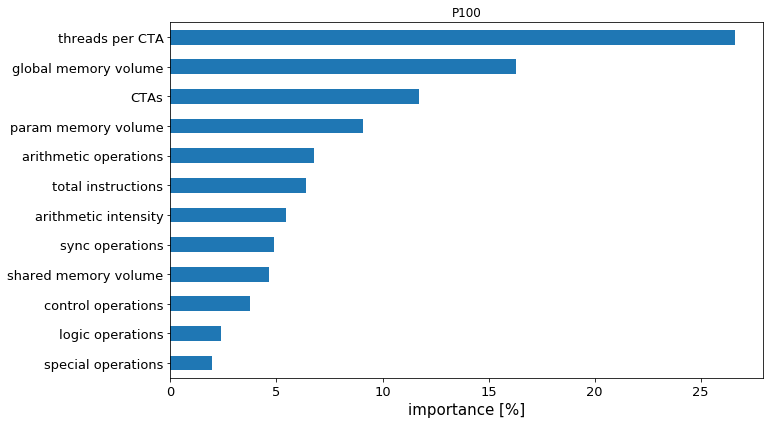

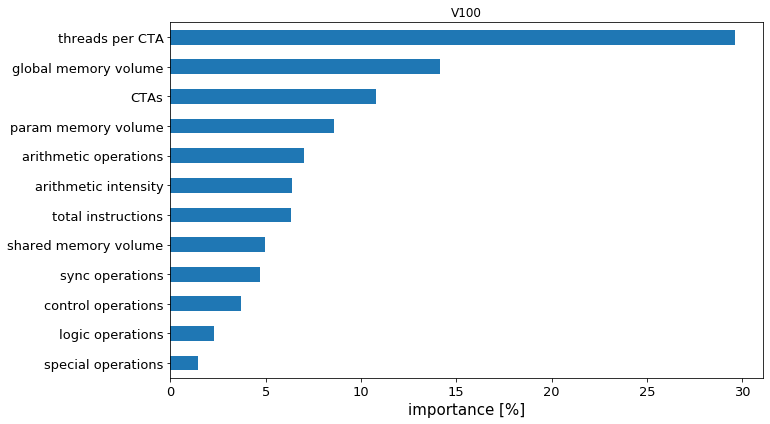

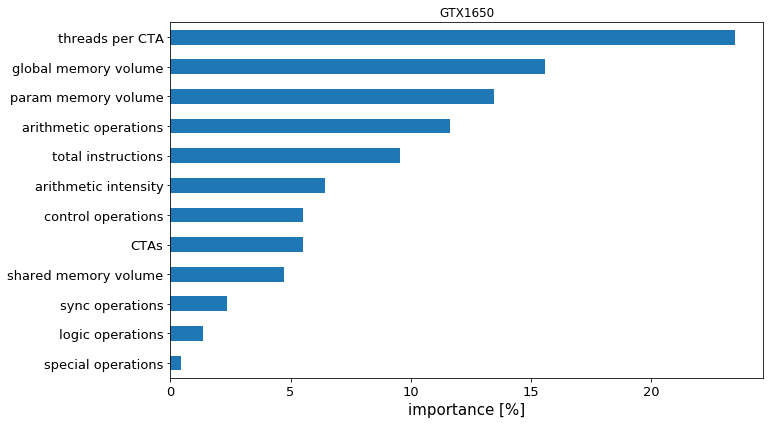

In [26]:
k20_dataset = pickle.load(open(files_time_samples_f['K20'],"rb"))
y_labels = [' '.join(label.split('_')) for label in k20_dataset.columns.values[4:-1]]

importances_all = pd.DataFrame()

for gpu in files_time_model:
    model = pickle.load(open(files_time_model[gpu],"rb"))
    feature_importance = 100 * model.regressor_.feature_importances_
    df = pd.DataFrame({'Importance':feature_importance}, index=y_labels)
    importances_all[gpu] = df['Importance']
    df.sort_values('Importance', inplace=True)
    df.plot.barh(legend=False, figsize=(10.8,6))
    plt.title(gpu)
    plt.xlabel('importance [%]')
    plt.tight_layout()
    plt.show()

In [27]:
importances_all

,K20,TitanXp,P100,V100,GTX1650
threads per CTA,23.193866,27.174541,26.620771,29.618209,23.492051
CTAs,8.473733,10.011266,11.740305,10.761984,5.506063
total instructions,7.902133,7.733439,6.404508,6.341240,9.572560
special operations,1.160774,1.529747,1.957796,1.456737,0.418595
logic operations,2.149038,2.584558,2.376308,2.297856,1.344450
control operations,4.406386,4.503446,3.747806,3.707006,5.508877
arithmetic operations,6.960966,8.116795,6.749887,7.011380,11.619193
sync operations,2.964673,3.542409,4.891734,4.708982,2.341855
global memory volume,12.459707,16.295197,16.295963,14.125607,15.588912
param memory volume,20.138977,8.152228,9.079770,8.604187,13.454803


### Power

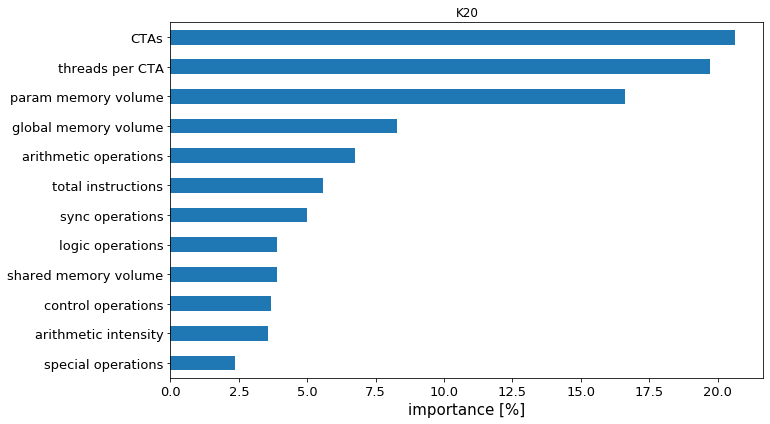

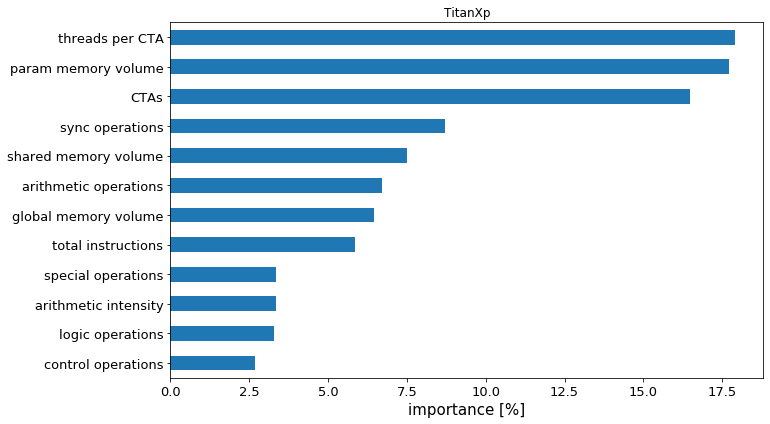

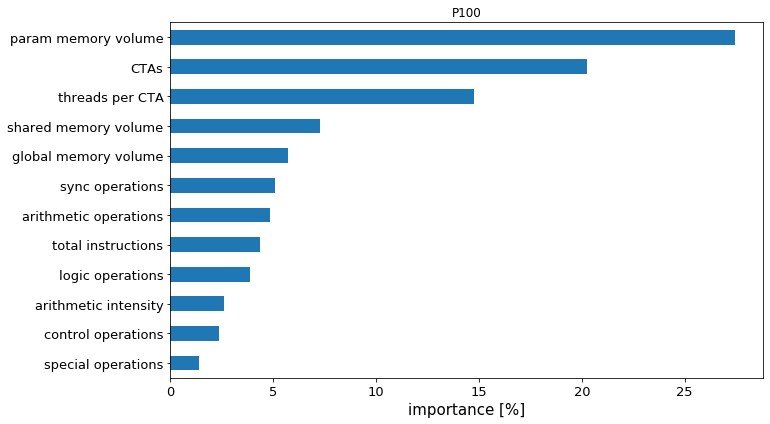

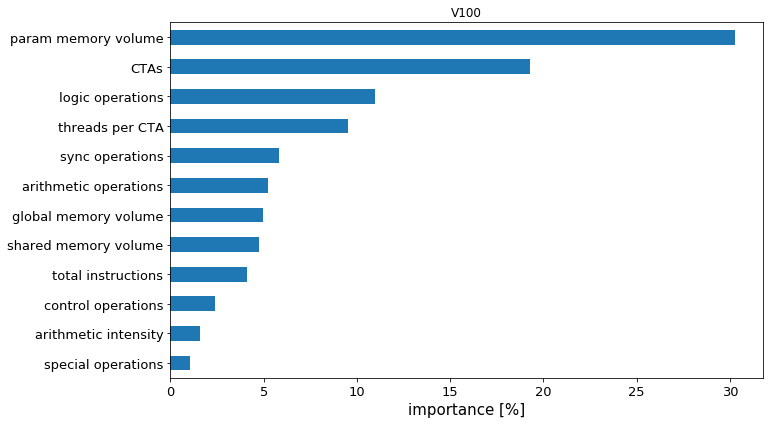

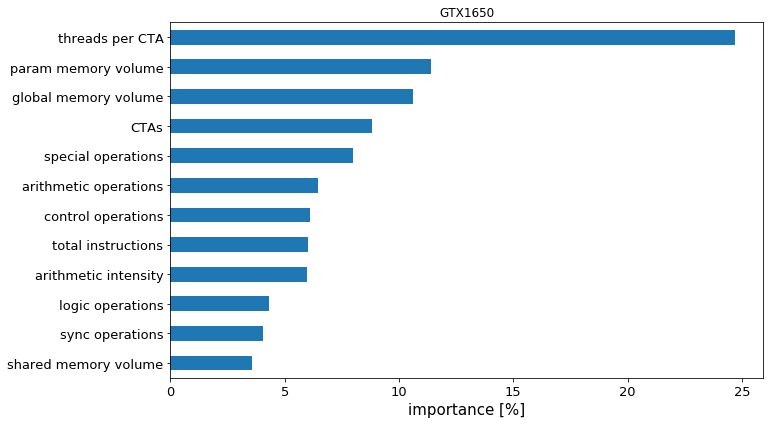

In [28]:
k20_dataset = pickle.load(open(files_power_samples_f['K20'],"rb"))
y_labels = [' '.join(label.split('_')) for label in k20_dataset.columns.values[4:-1]]

importances_all = pd.DataFrame()

for gpu in files_time_model:
    model = pickle.load(open(files_power_model[gpu],"rb"))
    feature_importance = 100 * model.feature_importances_
    df = pd.DataFrame({'Importance':feature_importance}, index=y_labels)
    importances_all[gpu] = df['Importance']
    df.sort_values('Importance', inplace=True)
    df.plot.barh(legend=False, figsize=(10.8,6))
    plt.title(gpu)
    plt.xlabel('importance [%]')
    plt.tight_layout()
    plt.show()

In [29]:
importances_all

,K20,TitanXp,P100,V100,GTX1650
threads per CTA,19.736130,17.907735,14.774958,9.517756,24.701192
CTAs,20.637908,16.486741,20.258739,19.278460,8.808179
total instructions,5.575723,5.841450,4.361914,4.103224,6.008559
special operations,2.371806,3.354527,1.388433,1.067875,7.996565
logic operations,3.905304,3.272107,3.873571,10.941708,4.322810
control operations,3.689498,2.675759,2.362378,2.410574,6.108731
arithmetic operations,6.749479,6.716401,4.835398,5.215498,6.464394
sync operations,4.974871,8.723629,5.081418,5.836254,4.048886
global memory volume,8.276006,6.469693,5.727549,4.987706,10.605202
param memory volume,16.627573,17.717204,27.450202,30.267897,11.393536


# LOO Analysis

## Time

In [30]:
dfj = pd.DataFrame()
for gpu in files_time_loo:
    loo_pred = pickle.load(open(files_time_loo[gpu], "rb"))
    dataset = pickle.load(open(files_time_samples_f[gpu],"rb"))
    dataset['LOO'] = loo_pred
    dataset['MAPE'] = 100 * np.abs(dataset['time'] - loo_pred)/dataset['time']    
    dataset = dataset[['bench','app', 'dataset', 'name','time', 'MAPE']].groupby(['bench','app', 'dataset', 'name']).max()

    dfj[gpu] = dataset['MAPE']

dfj['SUM'] = dfj.max(axis=1,skipna=True)
dfj.sort_values('SUM',inplace=True, ascending=False)
dfj

K20  \
bench             app      dataset        name                                                            
rodinia-3.1       lud_cuda large          _Z12lud_internalPfii                                34.442565   
                                          _Z13lud_perimeterPfii                               39.519679   
                  gaussian def_16         _Z4Fan1PfS_ii                                     1758.823529   
shoc              MaxFlops microbenchmark _Z8MulMAdd2IfEvPT_iS0_S0_                          263.801944   
rodinia-3.1       dwt2d    def_medium     _ZN8dwt_cuda12fdwt53KernelILi128ELi8EEEvPKiPiiii  1470.408163   
...                                                                                                 ...   
polybench-gpu-1.0 mvt.exe  s2             _Z11mvt_kernel2PfS_S_m                               0.115003   
                  atax.exe s2             _Z12atax_kernel2PfS_S_m                              0.114871   
                  3mm.exe  s2             _Z11mm3_kernel2PfS_S_m                               0.663156   
                                          _Z11mm3_kernel3PfS_S_m                               0.620489   
shoc              S3D      s4             _Z12ratx2_kernelIfEvPKT_PS0_S3_                      0.324224   

                                                                                               TitanXp  \
bench             app      dataset        name                                                           
rodinia-3.1       lud_cuda large          _Z12lud_internalPfii                               97.489918   
                                          _Z13lud_perimeterPfii                              70.867507   
                  gaussian def_16         _Z4Fan1PfS_ii                                     396.428571   
shoc              MaxFlops microbenchmark _Z8MulMAdd2IfEvPT_iS0_S0_                         226.357511   
rodinia-3.1       dwt2d    def_medium     _ZN8dwt_cuda12fdwt53KernelILi128ELi8EEEvPKiPiiii    2.564103   
...                                                                                                ...   
polybench-gpu-1.0 mvt.exe  s2             _Z11mvt_kernel2PfS_S_m                              0.354540   
                  atax.exe s2             _Z12atax_kernel2PfS_S_m                             0.355802   
                  3mm.exe  s2             _Z11mm3_kernel2PfS_S_m                              0.232906   
                                          _Z11mm3_kernel3PfS_S_m                              0.327139   
shoc              S3D      s4             _Z12ratx2_kernelIfEvPKT_PS0_S3_                     0.234067   

                                                                                                    P100  \
bench             app      dataset        name                                                             
rodinia-3.1       lud_cuda large          _Z12lud_internalPfii                              4.216800e+01   
                                          _Z13lud_perimeterPfii                             1.439852e+01   
                  gaussian def_16         _Z4Fan1PfS_ii                                     2.066667e+02   
shoc              MaxFlops microbenchmark _Z8MulMAdd2IfEvPT_iS0_S0_                         3.789222e+02   
rodinia-3.1       dwt2d    def_medium     _ZN8dwt_cuda12fdwt53KernelILi128ELi8EEEvPKiPiiii  3.295709e-12   
...                                                                                                  ...   
polybench-gpu-1.0 mvt.exe  s2             _Z11mvt_kernel2PfS_S_m                            9.321805e-01   
                  atax.exe s2             _Z12atax_kernel2PfS_S_m                           9.235711e-01   
                  3mm.exe  s2             _Z11mm3_kernel2PfS_S_m                            4.327251e-01   
                                          _Z11mm3_kernel3PfS_S_m                            3.348675e-01   
shoc              S3D      s4    

In [31]:
display(dfj.median(axis=0))

K20         9.137847
TitanXp     9.386898
P100        8.305612
V100        9.578931
GTX1650     8.458399
SUM        21.294785
dtype: float64

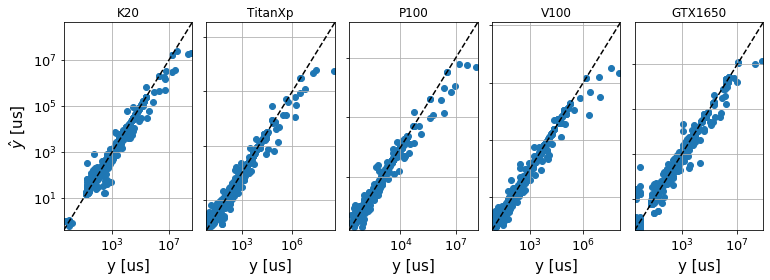

In [32]:
fig, axes = plt.subplots(1,len(gpus),figsize=(10.8,4))

i = 0
for gpu in gpus:
    loo_pred = pickle.load(open(files_time_loo[gpu], "rb"))
    dataset = pickle.load(open(files_time_samples_f[gpu],"rb"))
    time = dataset['time'].values
    guide_min = time.min()*0.8
    guide_max = time.max()*1.2


    axes[i].scatter(time, loo_pred)
    axes[i].plot([guide_min,guide_max], [guide_min,guide_max], '--', label='', color='black')
    axes[i].set_title(gpu)
    axes[i].set_xlabel('y [us]')
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    axes[i].set_ylim([guide_min,guide_max])
    axes[i].set_xlim([guide_min,guide_max])
    axes[i].grid()
    if gpu == 'K20':
        axes[i].set_ylabel(r'$\^y$ [us]')
    else:
        axes[i].set_yticklabels([''])
    i += 1


fig.tight_layout()
plt.savefig(plot_dir + '/LOO_Scores_time.pdf')
plt.show()

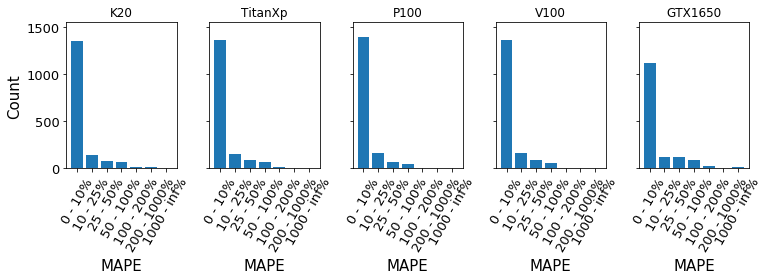

In [33]:
fig, axes = plt.subplots(1,len(gpus),figsize=(10.8,4))

j = 0
for gpu in gpus:
    loo_pred = pickle.load(open(files_time_loo[gpu], "rb"))
    dataset = pickle.load(open(files_time_samples_f[gpu],"rb"))
    mape = 100 * np.abs(dataset['time'] - loo_pred)/dataset['time']

    bins=[0, 10, 25, 50, 100, 200, 1000, float("Inf")]
    count, edges = np.histogram(mape, bins=bins)

    x = np.arange(len(count))
    xticklabels = []
    for i in range(0,len(edges)-1):
        xticklabels.append(str(edges[i]).rstrip('0').rstrip('.')+" - "+str(edges[i+1]).rstrip('0').rstrip('.')+"%")

    axes[j].bar(x, count, tick_label=xticklabels)
    axes[j].set_ylim(0,1550)
    axes[j].set_title(gpu)
    if gpu == 'K20':
        axes[j].set_ylabel('Count')
    else:
        axes[j].set_yticklabels([])
    axes[j].set_xlabel('MAPE')
    axes[j].xaxis.set_tick_params(rotation=60)
    
    j+=1
    
fig.tight_layout()
plt.savefig(plot_dir + '/LOO_Score_Histo_time.pdf')
plt.show()

## Power

In [34]:
dfj = pd.DataFrame()
for gpu in files_power_loo:
    loo_pred = pickle.load(open(files_power_loo[gpu], "rb"))
    dataset = pickle.load(open(files_power_samples_f[gpu],"rb"))
    dataset['LOO'] = loo_pred
    dataset['MAPE'] = 100 * np.abs(dataset['power'] - loo_pred)/dataset['power']
    dataset = dataset[['bench','app', 'dataset', 'name','power', 'MAPE']].groupby(['bench','app', 'dataset', 'name']).max()

    dfj[gpu] = dataset['MAPE']

dfj['SUM'] = dfj.max(axis=1,skipna=True)
dfj.sort_values('SUM',inplace=True, ascending=False)
dfj

K20  \
bench             app       dataset        name                                                   
polybench-gpu-1.0 syrk.exe  s1             _Z11syrk_kernelffPfS_m                     38.447508   
rodinia-3.1       dwt2d     def_small      _Z21c_CopySrcToComponentsIiEvPT_S1_S1_Phi  21.782467   
polybench-gpu-1.0 syr2k.exe s3             _Z12syr2k_kernelPfS_S_m                    16.311147   
shoc              MaxFlops  microbenchmark _Z5MAdd1IdEvPT_iS0_S0_                     34.992098   
                  Sort      s1             _Z11reorderDatajPjS_P5uint2S1_S_S_S_j      12.133851   
...                                                                                         ...   
                  S3D       s2             _Z12ratt7_kernelIfEvPKT_S2_PS0_S2_S0_       0.381356   
                                           _Z12ratx4_kernelIdEvPKT_PS0_S3_             0.440681   
                            s3             _Z12ratx4_kernelIfEvPKT_PS0_S3_             0.040662   
                            s1             _Z12ratt3_kernelIdEvPKT_S2_PS0_S2_S0_       0.168003   
                                           _Z12ratt8_kernelIdEvPKT_S2_PS0_S2_S0_       0.128155   

                                                                                        TitanXp  \
bench             app       dataset        name                                                   
polybench-gpu-1.0 syrk.exe  s1             _Z11syrk_kernelffPfS_m                     27.447613   
rodinia-3.1       dwt2d     def_small      _Z21c_CopySrcToComponentsIiEvPT_S1_S1_Phi  13.711573   
polybench-gpu-1.0 syr2k.exe s3             _Z12syr2k_kernelPfS_S_m                    48.647766   
shoc              MaxFlops  microbenchmark _Z5MAdd1IdEvPT_iS0_S0_                     16.907919   
                  Sort      s1             _Z11reorderDatajPjS_P5uint2S1_S_S_S_j      25.615617   
...                                                                                         ...   
                  S3D       s2             _Z12ratt7_kernelIfEvPKT_S2_PS0_S2_S0_       0.519417   
                                           _Z12ratx4_kernelIdEvPKT_PS0_S3_             0.514311   
                            s3             _Z12ratx4_kernelIfEvPKT_PS0_S3_             0.512145   
                            s1             _Z12ratt3_kernelIdEvPKT_S2_PS0_S2_S0_       0.467329   
                                           _Z12ratt8_kernelIdEvPKT_S2_PS0_S2_S0_       0.421664   

                                                                                           P100  \
bench             app       dataset        name                                                   
polybench-gpu-1.0 syrk.exe  s1             _Z11syrk_kernelffPfS_m                     64.908348   
rodinia-3.1       dwt2d     def_small      _Z21c_CopySrcToComponentsIiEvPT_S1_S1_Phi  59.059379   
polybench-gpu-1.0 syr2k.exe s3             _Z12syr2k_kernelPfS_S_m                    58.407803   
shoc              MaxFlops  microbenchmark _Z5MAdd1IdEvPT_iS0_S0_                     56.429933   
                  Sort      s1             _Z11reorderDatajPjS_P5uint2S1_S_S_S_j      45.719395   
...                                                                                         ...   
                  S3D       s2             _Z12ratt7_kernelIfEvPKT_S2_PS0_S2_S0_       0.249544   
                                           _Z12ratx4_kernelIdEvPKT_PS0_S3_             0.360075   
                            s3             _Z12ratx4_kernelIfEvPKT_PS0_S3_             0.116032   
                            s1             _Z12ratt3_kernelIdEvPKT_S2_PS0_S2_S0_       0.017435   
                                           _Z12ratt8_kernelIdEvPKT_S2_PS0_S2_S0_       0.032627   

                                                                                           V100  \
bench             app       dataset        name                                                   
polybench-gpu-1.0 syrk.exe  s1

In [35]:
display(dfj.median(axis=0))

K20        1.774645
TitanXp    2.609482
P100       4.093375
V100       3.305327
GTX1650    2.382025
SUM        7.006494
dtype: float64

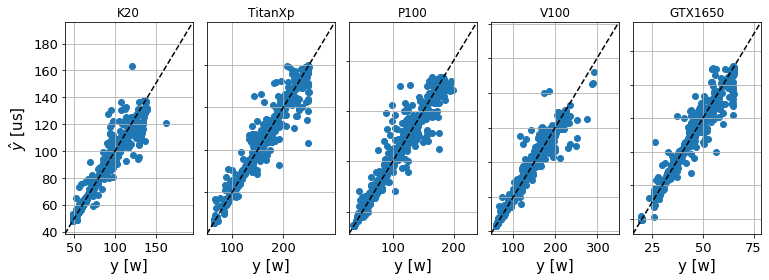

In [36]:
fig, axes = plt.subplots(1,len(gpus),figsize=(10.8,4))

i = 0
for gpu in gpus:
    loo_pred = pickle.load(open(files_power_loo[gpu], "rb"))
    dataset = pickle.load(open(files_power_samples_f[gpu],"rb"))
    time = dataset['power'].values
    guide_min = time.min()*0.8
    guide_max = time.max()*1.2

    axes[i].scatter(time, loo_pred)
    axes[i].plot([guide_min,guide_max], [guide_min,guide_max], '--', label='', color='black')
    axes[i].set_title(gpu)
    axes[i].set_xlabel('y [w]')
    axes[i].set_ylim([guide_min,guide_max])
    axes[i].set_xlim([guide_min,guide_max])
    axes[i].grid()
    if gpu == 'K20':
        axes[i].set_ylabel(r'$\^y$ [us]')
    else:
        axes[i].set_yticklabels([''])
    i += 1

fig.tight_layout()
plt.savefig(plot_dir + '/LOO_Scores_power.pdf')
plt.show()

# Kernel Count

In [37]:
print('GPU\t\tNum Kernels:')

for gpu in files_time_samples_f:
    df = pickle.load(open(files_time_samples_f[gpu], 'rb'))
    print(gpu,'\t\t',df[['bench', 'app', 'name']].drop_duplicates().shape[0])

GPU		Num Kernels:
K20 		 186
TitanXp 		 181
P100 		 181
V100 		 181
GTX1650 		 181


# ThreadGrid Statistics

In [38]:
with sqlite3.Connection(file_features) as conn:
    df = pd.read_sql_query('select distinct bench,app,dataset,name,gX,gY,gZ,bX,"bY",bz,shm from fluxfeatures;', conn)

In [39]:
cc_map = { 'K20': 3.5, 
          'TitanXp': 6.0, 
          'P100': 6.0, 
          'V100': 7.0,
          'GTX1650': 7.5}

sm_map = { 'K20': 13, 
          'TitanXp': 30, 
          'P100': 56, 
          'V100': 80,
          'GTX1650': 14}

max_res_block_sm = { 3.5: 16,
                   6.0: 32,
                   7.0: 32,
                   7.5: 16}

max_res_threads_sm = { 3.5: 2048,
                   6.0: 2048,
                   7.0: 2048,
                   7.5: 1024}

max_shm_sm = { 3.5: 48*1024,
               6.0: 64*1024,
               7.0: 96*1024,
               7.5: 60*1024}

for gpu in cc_map:
    cc = cc_map[gpu]
    
    threads = df['bX'] * df['bY'] * df['bZ'] # per block
    blocks = df['gX'] * df['gY'] * df['gZ']
    block_lim_thread = max_res_threads_sm[cc] // threads
    block_lim_shm = max_shm_sm[cc] // df['shm']
    block_lim_shm.fillna(max_res_block_sm[cc],inplace=True)
    block_lim = np.minimum(np.ones(block_lim_thread.shape) * max_res_block_sm[cc], block_lim_thread.values)
    block_lim = np.minimum(block_lim, block_lim_shm)
    #block_lim = np.ones(block_lim_thread.shape) * max_res_block_sm[cc]
    sm_used = blocks / (block_lim)
    sm_cap_exceeded = sm_used > sm_map[gpu]
    #print(sm_cap_exceeded.value_counts())
    #print(df.iloc[:2])
    print(gpu,(sm_cap_exceeded.value_counts()[False]/sm_cap_exceeded.shape)[0])

K20 0.14585434738753278
TitanXp 0.31652208997377446
P100 0.5063546499899133
V100 0.560823078474884
GTX1650 0.1400040346984063


# Variance Investigation

In [40]:
groups = {'lseq': ['bench', 'app', 'dataset', 'lseq'],
          'lconf': ['bench','app','dataset','name',
                    'gX','gY','gZ','bX','bY','bZ','shm',
                    'control','int.32','int.64','total_inst']}

with sqlite3.Connection(file_features) as conn:
    df_features = pd.read_sql_query("select * from fluxfeatures", conn)

df_list = []
for gpu in files_time_kernel:
    
    with sqlite3.Connection(files_time_kernel[gpu]) as conn:
        df_time = pd.read_sql_query("select * from kerneltime", conn)
    df_list.append(df_time.merge(df_features, on=['bench','app','dataset','lseq'], how='inner').groupby(groups['lconf'])[['bench','app','dataset','name','time']].agg(([np.median, np.mean, np.std])))
    df_list[-1]['gpu'] = gpu

df_all = pd.concat(df_list)

In [41]:
with pd.option_context("display.max_rows", 100):
    tmp = df_all.reset_index()[['bench','app','dataset','name','gpu','time']].sort_values(('time','std'), ascending=False)
    display(tmp.iloc[:50])

bench                app         dataset  \
                                                               
99385   polybench-gpu-1.0          syr2k.exe              s3   
36445   polybench-gpu-1.0          syr2k.exe              s3   
78405   polybench-gpu-1.0          syr2k.exe              s3   
15490   polybench-gpu-1.0          syr2k.exe              s3   
78404   polybench-gpu-1.0          syr2k.exe              s2   
36444   polybench-gpu-1.0          syr2k.exe              s2   
99384   polybench-gpu-1.0          syr2k.exe              s2   
1123    polybench-gpu-1.0     covariance.exe              s3   
41592                shoc           MaxFlops  microbenchmark   
69      polybench-gpu-1.0  3DConvolution.exe              s3   
57425   polybench-gpu-1.0          syr2k.exe              s3   
22078   polybench-gpu-1.0     covariance.exe              s3   
64038   polybench-gpu-1.0     covariance.exe              s3   
1120    polybench-gpu-1.0     covariance.exe              s2   
85018   polybench-gpu-1.0     covariance.exe              s3   
41566                shoc           MaxFlops  microbenchmark   
36448   polybench-gpu-1.0           syrk.exe              s3   
20612                shoc           MaxFlops  microbenchmark   
41565                shoc            MD5Hash              s4   
21018   polybench-gpu-1.0            2mm.exe              s2   
36443   polybench-gpu-1.0          syr2k.exe              s1   
83961   polybench-gpu-1.0            2mm.exe              s3   
83960   polybench-gpu-1.0            2mm.exe              s3   
41575                shoc           MaxFlops  microbenchmark   
41577                shoc           MaxFlops  microbenchmark   
41581                shoc           MaxFlops  microbenchmark   
41579                shoc           MaxFlops  microbenchmark   
64035   polybench-gpu-1.0     covariance.exe              s2   
41593                shoc           MaxFlops  microbenchmark   
41600                shoc           MaxFlops  microbenchmark   
41598                shoc           MaxFlops  microbenchmark   
41595                shoc           MaxFlops  microbenchmark   
20611                shoc           MaxFlops  microbenchmark   
43058   polybench-gpu-1.0     covariance.exe              s3   
22075   polybench-gpu-1.0     covariance.exe              s2   
41567                shoc           MaxFlops  microbenchmark   
41569                shoc           MaxFlops  microbenchmark   
41571                shoc           MaxFlops  microbenchmark   
41573                shoc           MaxFlops  microbenchmark   
41583                shoc           MaxFlops  microbenchmark   
41587                shoc           MaxFlops  microbenchmark   
41589                shoc           MaxFlops  microbenchmark   
41585                shoc           MaxFlops  microbenchmark   
20586                shoc           MaxFlops  microbenchmark   
21020   polybench-gpu-1.0            2mm.exe              s3   
104519               shoc           MaxFlops  microbenchmark   
104521               shoc           MaxFlops  microbenchmark   
104517               shoc           MaxFlops  microbenchmark   
21021   polybench-gpu-1.0            2mm.exe              s3   
104515               shoc           MaxFlops  microbenchmark   

                                             name      gpu         time  \
                                                                 median   
99385                     _Z12syr2k_kernelPfS_S_m  GTX1650  630874862.0   
36445                     _Z12syr2k_kernelPfS_S_m  TitanXp  276706687.5   
78405                     _Z12syr2k_kernelPfS_S_m     V100  105339205.5   
15490                     _Z12syr2k_kernelPfS_S_m      K20  341598256.0   
78404                     _Z12syr2k_kernelPfS_S_m     V100    7458038.0   
36444                     _Z12syr2k_kernelPfS_S_m  TitanXp   15984764.0   
99384                     _Z12syr2k_kernelPfS_S_m  GTX1650   11872544.5   
1123            

In [42]:
groups = {'lseq': ['bench', 'app', 'dataset', 'lseq'],
          'lconf': ['bench','app','dataset','name',
                    'gX','gY','gZ','bX','bY','bZ','shm',
                    'control','int.32','int.64','total_inst']}

with sqlite3.Connection(file_features) as conn:
    df_features = pd.read_sql_query("select * from fluxfeatures", conn)
    
loo_complete = {}

for gpu in gpus:
    with sqlite3.Connection(files_time_kernel[gpu]) as conn:
        df_time = pd.read_sql_query("select * from kerneltime", conn)
    df_merged = df_time.merge(df_features, on=['bench','app','dataset','lseq'], how='inner')
    df_merged = df_merged.groupby(groups['lconf']).median()
    mean = df_merged.groupby(groups['lconf'])['time'].mean().values
    std = df_time.merge(df_features, on=['bench','app','dataset','lseq'], how='inner').groupby(groups['lconf'])['time'].std().values
    df_merged = df_merged.reset_index()
    df_merged = gmu.process_features(df_merged)
    df_merged['time_mean'] = mean
    df_merged['time_std'] = std
    
    loo_pred = pickle.load(open(data_dir + "/time_loo_"+gpu+"_median_100.pkl", "rb"))
    dataset = pickle.load(open(data_dir + "/time_samplesf_"+gpu+"_median_100.pkl","rb"))
    dataset['loo'] = loo_pred

    if 'arithmetic_opeations' in dataset.columns:
        dataset['arithmetic_operations'] = dataset['arithmetic_opeations']
    df_complete = df_merged.merge(dataset, on=['bench', 'app', 'dataset', 'name', 'threads_per_CTA', 'CTAs',
       'total_instructions', 'special_operations', 'logic_operations',
       'control_operations', 'arithmetic_operations', 'sync_operations',
       'global_memory_volume', 'param_memory_volume', 'shared_memory_volume',
       'arithmetic_intensity'], how='inner')
    loo_complete[gpu] = df_complete

/share/lbraun/repos/jupyter/gpu-mangrove/gpumangrove/utils.py:82: RuntimeWarning: invalid value encountered in true_divide
  cols['global_memory_volume'] + cols['param_memory_volume'])


No handles with labels found to put in legend.


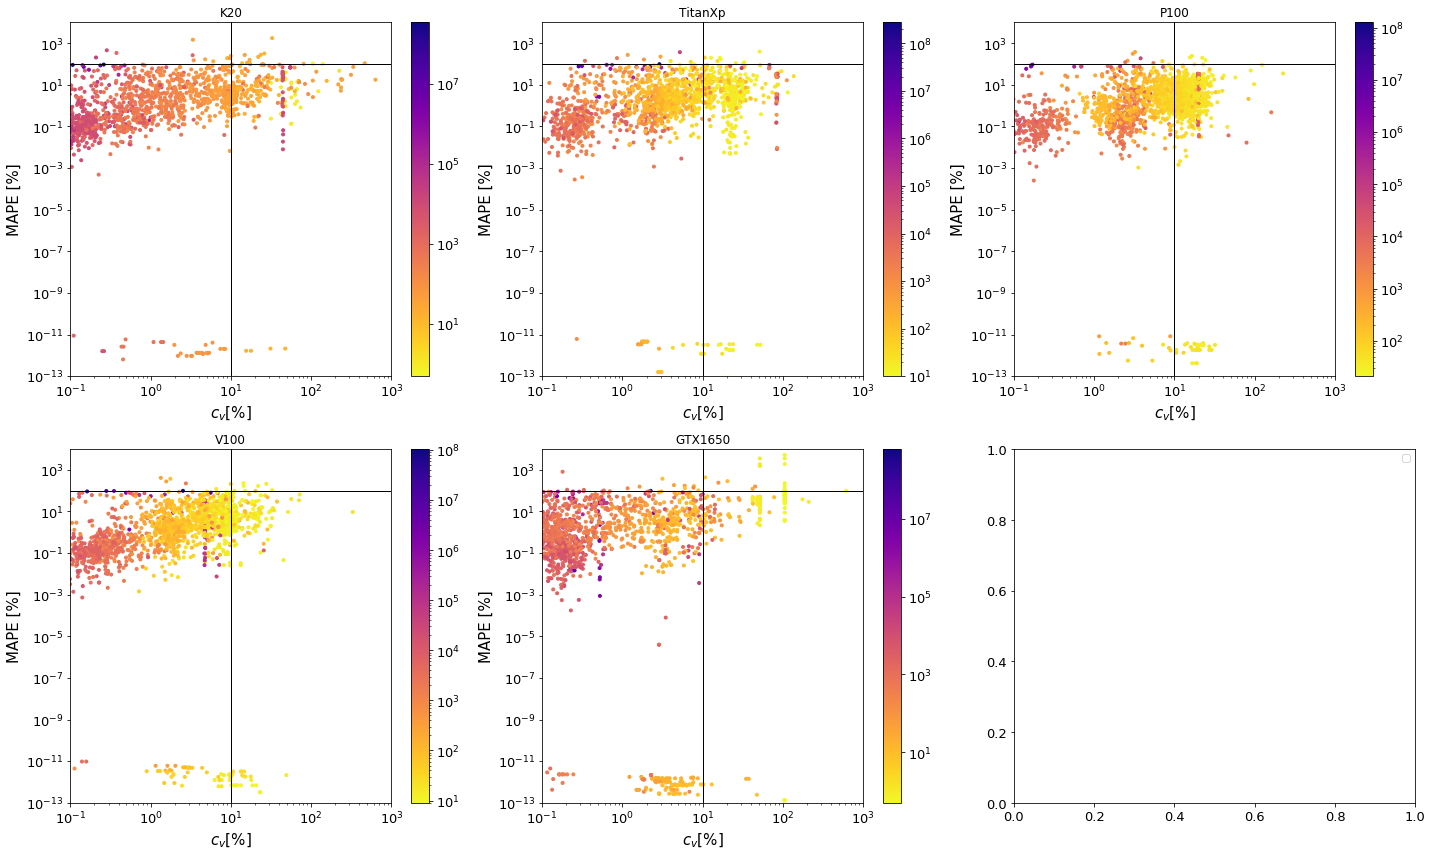

In [43]:
fig, axes = plt.subplots(2,3,figsize=(20,12))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

i = 0
for gpu in gpus:
    mape = 100 * np.abs(loo_complete[gpu]['time_x'] - loo_complete[gpu]['loo'])/loo_complete[gpu]['time_x']
    axes[i//3][i%3].set_title(gpu)
    axes[i//3][i%3].set_yscale('log')
    axes[i//3][i%3].set_xscale('log')
    axes[i//3][i%3].set_xlabel(r'$c_v [\%]$')
    axes[i//3][i%3].set_ylabel('MAPE [%]')
    axes[i//3][i%3].set_ylim(10e-14, 10e3)
    axes[i//3][i%3].set_xlim(10e-2,10e2)
    res = axes[i//3][i%3].scatter(100*loo_complete[gpu]['time_std']/loo_complete[gpu]['time_mean'],mape , marker=".",c=loo_complete[gpu]['time_x'], cmap='plasma_r',norm=mpl.colors.LogNorm())
    fig.colorbar(res,ax=axes[i//3][i%3])
    # 100% MAPE bar
    axes[i//3][i%3].plot([10e-3, 10e4], [100, 100], color='black', lw=1)
    # 10% variance bar
    axes[i//3][i%3].plot([10, 10], [10e-15, 10e5], color='black', lw=1)
    i+=1

fig.tight_layout()
plt.legend()
plt.show()